<a href="https://colab.research.google.com/github/diegorodriguez31/database_inha/blob/main/RODRIGUEZ_Diego_Database_midterm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Diego Rodriguez : 12224836
# Midterm assignement: creating a ITS Database

The report is represented by this colab file. I will explain every choice that I made for designing and implementing this database.
All files used will be present in the corresponding archive available on i-class.

#Context
An ITS company needs a vehicle reservation service for officials of the Incheon games. The goal is to have an efficient database in order to be able to make reservations without any problem.

# Data Entity-Relationship diagram

As you can see, I can't use Erwin modeler on my computer because I work under Unix distribution. So I decided to represent my ITS database with a program called Looping (https://www.looping-mcd.fr/). This is a program I discovered during my studies in France. It is more complete and easy to use than Moon modeler, so I decided to use it.

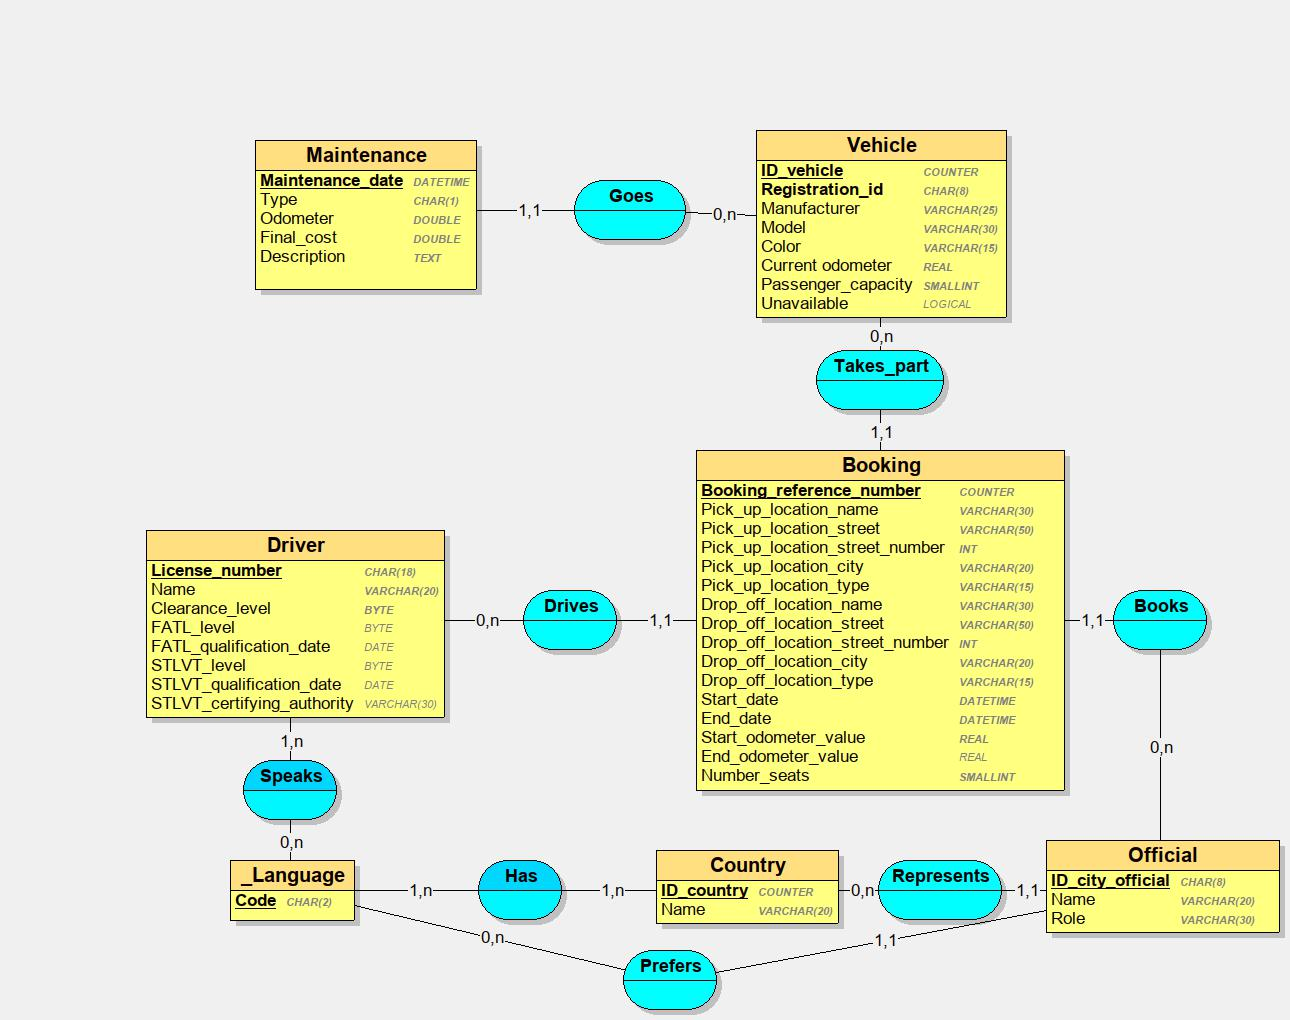

The above diagram represents my understanding of the subject. The tables, relationships and cardinalities represent the skeleton of the database.
So we have vehicles that can be in maintenance. Officials speak a language and come from a country. They can make a reservation including themselves, a driver and a car. The driver also speaks a certain language.
Each official prefers a certain language and if from a country. It is possible that a country is not represented by any offcicial. Idem for the languages. A booking consist of the representation of an official, a driver and a vehicle.
Here are the delicate points I have dealt with and that I want to clarify:
- My "Language" table is called "_Language" because "Language" is a SQL keyword. So I added an underscore.
- I decided to put all the information of pick-up address and drop-off address in the booking table. It results with a lot of attribute but it's easier to handle even if the information seems redundant.
- At the end of the booking, the user will have to add the information from the booking table "End_odometer_value". He may not fill in this information at the beginning because he does not have it yet.
- The official must indicate the number of seats he wants so that the search will show only the vehicles that have enough seats.
- You can see on the diagram that depending on the attributes, I put maximum sizes (VARCHAR) more or less long. For example for the color of a car, 15 characters are enough.
- I considered that it's not possible to have multiple maintenance at the same exact second. The I put the date only as primary key.
- As I did with the address in booking, I let FATL and STLVT information in the Driver table and I put these attributes as NULLABLE if the driver don't have one of these certification or both of them.
- Depending on the attribute, I decided to put different types like booleen for the unavailable flag or Reel for the odometer value.
- Most attributes cannot be set to null except for a few attributes for which information is not always available or if the attribute is not mandatory such as the FATL certification of a driver.
- For the ID of a vehicle, I decided to put an integer that autoincremented unlike the example of the subject. It's easier to handle like that.
- The official can use the delivery service several times. Thus, the format of the reservation dates is DATETIME "YYYY-MM-DD HH:MM:SS". Just compare the strings with each other to compare the dates.
- You will see later in the topic that I have put triggers that prevent to insert a reservation if the vehicle, the driver or the official are already occupied.
- I put a flag unavailable in the vehicle class to indicate if a vehicle is available or not. However, I think this is only useful if the car is in maintenance or temporarily available. Since cars can be reserved in advance, there is no way to specify that the flag will be unavailable at a certain time. So the unavailable flag will be set to 1 by the user when a car is in maintenance or repair. If a car is not available because it is already in use in a certain reservation for a certain period of time, then this will be handled by the application which will perform a query that searches for all available vehicles for the period of time the official is looking for. So, when an official is looking to reserve a car, the application will only display the cars available for the specified time period.
- I made to triggers to verify before a booking that the driver and the official speak the same language and that the vehicle has enough capacity for the seats.
- In the subject, a sentence is the following "ITS driver booking service matches the assignment of a suitable driver with a
suitable vehicle based on the Incheon game official's request". I interpreted that all drivers have the basic license that allows them to drive all types of cars that require only the car license. An official could also choose drivers based on their FATL or STLVT level. For this, when they look at the reservations offered on the application, they should choose the driver that suits them best.

# Script for creating the tables

In [1]:
from sqlalchemy import create_engine
my_conn = create_engine("sqlite:////content/ITS.db")
conn = my_conn.connect()

### Vehicle
Registration_id is Unique because it's not the primary key but I think that it's not possible that two vehicles have the same registration ID. The user has to set the flag unavailable to 1 when the vehicle is sent in maintenance or reparation or any other problem. If the vehicle is booked, it's the request made by the application that will not show the vehicle to the official user. At each new car, the id auto-increment. We need to fill every field when adding a new vehicle.

In [3]:
my_conn.execute('''CREATE TABLE Vehicle(
   ID_vehicle INTEGER PRIMARY KEY AUTOINCREMENT,
   Registration_id CHAR(8) NOT NULL,
   Manufacturer VARCHAR(25) NOT NULL,
   Model VARCHAR(30) NOT NULL,
   Color VARCHAR(15) NOT NULL,
   Current_odometer REAL NOT NULL,
   Passenger_capacity SMALLINT NOT NULL,
   Unavailable LOGICAL NOT NULL,
   UNIQUE(Registration_id)
);''')

### Country
I put the maximum length of the name of a country of 20, I think it's enough. Each new country have an ID that is auto-incrementing. Every field has to be set.

In [5]:
my_conn.execute('''CREATE TABLE Country(
   ID_country INTEGER PRIMARY KEY AUTOINCREMENT,
   Name VARCHAR(20) NOT NULL
);''')

### _Language
As I already explained, I have to add the underscore on this table name beacause "Language" is a SQL reserved word. I think that the Code is enough to identify a language, so I only put this information in this table. Every field has to be set.

In [6]:
my_conn.execute('''CREATE TABLE _Language(
   Code CHAR(2),
   PRIMARY KEY(Code)
);''')

### Official
Every field need to be set. An officiel references a country he represents and the language he prefers. Each official has an ID of 8 character decided by ITS.

In [7]:
my_conn.execute('''CREATE TABLE Official(
   ID_city_official CHAR(8),
   Name VARCHAR(20) NOT NULL,
   Role VARCHAR(30) NOT NULL,
   ID_country INT NOT NULL,
   Code CHAR(2) NOT NULL,
   PRIMARY KEY(ID_city_official),
   FOREIGN KEY(ID_country) REFERENCES Country(ID_country),
   FOREIGN KEY(Code) REFERENCES _Language(Code)
);''')

### Driver
In this table, the information about FATL and STLVT can be ommitted.
But it is important that if there is an information about FATL, all information about FATL must be fulfilled. If there is no information about FATL, every FATL attribute need to don't have any information (null). So it's either everything null or everything not null. It's the exact same process with information about STLVT.
There are some constraints to verify that.
Also, there are some constraints verifying that clearance level is between 1 and 4, FATL level is between 1 and 10 and STLVT level is between 1 and 5.
The license number of a driver is 18 characters.

In [8]:
my_conn.execute('''CREATE TABLE Driver(
   License_number CHAR(18),
   Name VARCHAR(20) NOT NULL,
   Clearance_level BYTE NOT NULL,
   FATL_level BYTE,
   FATL_qualification_date DATE,
   STLVT_level BYTE,
   STLVT_qualification_date DATE,
   STLVT_certifying_authority VARCHAR(30),
   PRIMARY KEY(License_number),
   CONSTRAINT CHECK_Clearance_Level CHECK (Clearance_level > 0 AND Clearance_level < 5), 
   CONSTRAINT CHECK_FATL_Level CHECK (FATL_level > 0 AND FATL_level < 11),
   CONSTRAINT CHECK_STLVT_Level CHECK (STLVT_level > 0 and STLVT_level < 6),
   CONSTRAINT CHECK_FATL_Information_Consistency CHECK(
    (FATL_level IS NULL AND FATL_qualification_date IS NULL)
    OR (FATL_level IS NOT NULL AND FATL_qualification_date IS NOT NULL)),
   CONSTRAINT CHECK_STLVT_Information_Consistency CHECK(
    (STLVT_level IS NULL AND STLVT_qualification_date IS NULL AND STLVT_certifying_authority IS NULL)
    OR (STLVT_level IS NOT NULL AND STLVT_qualification_date IS NOT NULL AND STLVT_certifying_authority IS NOT NULL))
);''')

### Booking
This table is fulfilled when a new reservation is made by an official. The ID is auto-incremented and every field has to be fulfilled expect for End_odometer because we can't know this information until the end of the reservation. We can see that information are redundant with pick_up and drop_off addresses. I could also make a table for addresses but I decided to let a lot of attribute in this table, it's not really different because there is not a lot of information. If the database were bigger, I should separate address in another table. I decided the size of VARCHAR according to the lenght of addresses that I know. The start and end dates are DATETIME so we know precisely the time of each booking. The attribute number of seats is usefull to know if we can assign a particular vehicle for the book if it has enough seats. Of course, the booking reference a Driver, a Vehicle and A Official. We will see with the triggers after that we can't book at the same time the 3 entities. With another trigger we will see the checking of seats and also verifying that the driver speaks the same language as the official. It's important so that they can communicate the address or if there is any problem, they can communicate easily.

In [9]:
my_conn.execute('''CREATE TABLE Booking(
   Booking_reference_number INTEGER PRIMARY KEY AUTOINCREMENT,
   Pick_up_location_name VARCHAR(30) NOT NULL,
   Pick_up_location_street VARCHAR(50) NOT NULL,
   Pick_up_location_street_number INT NOT NULL,
   Pick_up_location_city VARCHAR(20) NOT NULL,
   Pick_up_location_type VARCHAR(15) NOT NULL,
   Drop_off_location_name VARCHAR(30) NOT NULL,
   Drop_off_location_street VARCHAR(50) NOT NULL,
   Drop_off_location_street_number INT NOT NULL,
   Drop_off_location_city VARCHAR(20) NOT NULL,
   Drop_off_location_type VARCHAR(15) NOT NULL,
   Start_date DATETIME NOT NULL,
   End_date DATETIME NOT NULL,
   Start_odometer_value REAL NOT NULL,
   End_odometer_value REAL,
   Number_seats SMALLINT NOT NULL,
   License_number CHAR(18) NOT NULL,
   ID_city_official CHAR(8) NOT NULL,
   ID_vehicle INT NOT NULL,
   FOREIGN KEY(License_number) REFERENCES Driver(License_number),
   FOREIGN KEY(ID_city_official) REFERENCES Official(ID_city_official),
   FOREIGN KEY(ID_vehicle) REFERENCES Vehicle(ID_vehicle)
);''')

### Maintenance
We need to fill every information when adding a new maintenance. Each of them is identify by the exact time of the maintenance. There is a constraint telling that the value of the type can be only M or R. Each maintenance references a vehicle.

In [10]:
my_conn.execute('''CREATE TABLE Maintenance(
   Maintenance_date DATETIME,
   Type CHAR(1) NOT NULL,
   Odometer DOUBLE NOT NULL,
   Final_cost DOUBLE NOT NULL,
   Description TEXT NOT NULL,
   ID_vehicle INT NOT NULL,
   PRIMARY KEY(Maintenance_date),
   FOREIGN KEY(ID_vehicle) REFERENCES Vehicle(ID_vehicle)
   CONSTRAINT CHECK_Maintenance_Type CHECK (Type = 'M' OR Type = 'R')
);''')

### Has
This table is the relation(n-n) between countries and languages. It associate the primary key of the country with the primary key of the language. It's usefull to know which languages can be spoken in a country or from which country are a particular language. So we put in relation the foreign key of countries and languages.

In [11]:
my_conn.execute('''CREATE TABLE Has(
   ID_country INT,
   Code CHAR(2),
   PRIMARY KEY(ID_country, Code),
   FOREIGN KEY(ID_country) REFERENCES Country(ID_country),
   FOREIGN KEY(Code) REFERENCES _Language(Code)
);''')

### Speaks

This table is the relation (n-n) between drivers and languages. It associate the primary key of the driver with the primary key of the language. It will be usefull is the triggers later. So we put in relation the foreign key of drivers and languages.

In [12]:
my_conn.execute('''CREATE TABLE Speaks(
   Code CHAR(2),
   License_number CHAR(18),
   PRIMARY KEY(Code, License_number),
   FOREIGN KEY(Code) REFERENCES _Language(Code),
   FOREIGN KEY(License_number) REFERENCES Driver(License_number)
);''')

# Checking if all tables exist

In [13]:
r_set = my_conn.execute('''select name from sqlite_master 
  where type = 'table' ''')
for row in r_set:
  print(row)

('Vehicle',)
('sqlite_sequence',)
('Country',)
('_Language',)
('Official',)
('Driver',)
('Booking',)
('Maintenance',)
('Has',)
('Speaks',)


# Triggers

Now, I have to insert trigger in order to prevent the user to insert data that is not possible and that can break the system. For example if the official wants to book a vehicle that doesn't have enough seats, it will not be possible and raise an error.

### Overlapping Vehicle
This trigger prevent from inserting a vehicle that is already booked for the period of time of the booking.

In [38]:
my_conn.execute('''CREATE TRIGGER IF NOT EXISTS TRIGGER_Booked_Vehicle_Slot_Is_Overlapping
BEFORE INSERT
ON Booking
FOR EACH ROW
    WHEN (SELECT COUNT(*)
        FROM Booking, Vehicle
        WHERE Booking.ID_vehicle = Vehicle.ID_vehicle
        AND Booking.ID_vehicle = NEW.ID_vehicle
        AND NEW.End_Date >= Booking.Start_Date
        AND NEW.Start_Date <= Booking.End_Date
        ) > 0
BEGIN
    SELECT RAISE(ABORT, 'This vehicle has already been booked for this slot of time');
END;''')

### Overlapping Driver
This trigger prevent from inserting a driver that is already booked for the period of time of the booking.

In [15]:
my_conn.execute('''CREATE TRIGGER IF NOT EXISTS TRIGGER_Booked_Driver_Slot_Is_Overlapping
BEFORE INSERT
ON Booking
FOR EACH ROW
    WHEN (SELECT COUNT(*)
        FROM Booking, Driver
        WHERE Booking.License_number = Driver.License_number
        AND Booking.License_number = NEW.License_number
        AND NEW.End_Date >= Booking.Start_Date
        AND NEW.Start_Date <= Booking.End_Date
        ) > 0
BEGIN
    SELECT RAISE(ABORT, 'This driver has already been booked for this slot of time');
END;''')

### Overlapping official
This trigger prevent from inserting an official that is already booked for the period of time of the booking.

In [16]:
my_conn.execute('''CREATE TRIGGER IF NOT EXISTS TRIGGER_Booked_Official_Slot_Is_Overlapping
BEFORE INSERT
ON Booking
FOR EACH ROW
    WHEN (SELECT COUNT(*)
        FROM Booking, Official
        WHERE Booking.ID_city_official = Official.ID_city_official
        AND Booking.ID_city_official = NEW.ID_city_official
        AND NEW.End_Date >= Booking.Start_Date
        AND NEW.Start_Date <= Booking.End_Date
        ) > 0
BEGIN
    SELECT RAISE(ABORT, 'This official has already been booked for this slot of time');
END;''')

### Same language
This trigger prevent from inserting an official that doesn't speak the same language as the driver.

In [35]:
my_conn.execute('''CREATE TRIGGER IF NOT EXISTS TRIGGER_Driver_And_Official_Have_Same_Language
BEFORE INSERT
ON Booking
FOR EACH ROW
    WHEN (SELECT COUNT(*)
        FROM Driver, Official, Speaks
        WHERE Official.ID_city_official = NEW.ID_city_official
        AND Driver.License_number = NEW.License_number
        AND Driver.License_number = Speaks.License_number
        AND Speaks.Code = Official.Code
        ) == 0
BEGIN
    SELECT RAISE(ABORT, 'The driver and the official do not speak the same language');
END;''')

### Number of seats available
This trigger prevent from inserting a vehicle that doesn't have enough seats for the official and the other person that need to enter in the vehicle. The official needs to enter the number of seats that he needs before booking.

In [32]:
my_conn.execute('''CREATE TRIGGER IF NOT EXISTS TRIGGER_Enough_Seats
BEFORE INSERT
ON Booking
FOR EACH ROW
    WHEN (SELECT COUNT(*)
        FROM Vehicle
        WHERE Vehicle.ID_vehicle = NEW.ID_vehicle
        AND NEW.Number_seats <= Vehicle.Passenger_capacity
        ) == 0
BEGIN
    SELECT RAISE(ABORT, 'There is not enough seats in this vehicle for this reservation');
END;''')

# Inserting the data

Now that the database is properly created with all the tables and triggers, we can instert in it data to test it and to see if everything works as planned. Below, I will insert all data in all tables. There is not so much to explain here except that I just need to respect the order of insertion of the attribute in the table as long as their type (INT, VARCHAR...). I invented the data so it's not the real values that would be used by ITS but I tried to put some values that respect the idea of ITS events.

### Insert in Vehicle

In [19]:
my_conn.execute('''INSERT INTO Vehicle (ID_vehicle, Registration_id, Manufacturer, Model, Color, Current_odometer, Passenger_capacity, Unavailable) VALUES
(1, 'AB-123-CD', 'Volkswagen', 'Golf', 'Blue', 10000, 5, 0),
(2, 'AB-456-CD', 'Volvo', 'XC90 SE', 'Silver', 20000, 3, 0),
(3, 'AB-789-CD', 'Volkswagen', 'Golf', 'Green', 30000, 3, 0),
(4, 'AB-012-CD', 'Volkswagen', 'Golf', 'Yellow', 40000, 3, 0),
(5, 'AB-345-CD', 'Kia', 'K7', 'Black', 50000, 4, 0),
(6, 'AB-678-CD', 'Volkswagen', 'Golf', 'White', 60000, 3, 0),
(7, 'AB-901-CD', 'Tesla', '2020 F', 'White', 70000, 2, 1),
(8, 'AB-234-CD', 'Ford', 'Transit', 'Silver', 80000, 3, 1),
(9, 'AB-567-CD', 'Hyundai', 'i30', 'Green', 90000, 4, 0),
(10, 'AB-890-CD', 'Hyundai', 'i30', 'Yellow', 100000, 2, 0),
(11, 'AB-123-DE', 'Hyundai', 'i30', 'Black', 110000, 3, 0),
(12, 'AB-456-DE', 'Hyundai', 'i30', 'White', 120000, 1, 0);''')

### Insert in Country

In [20]:
my_conn.execute('''INSERT INTO Country (ID_country, Name) VALUES
(1, 'Belgium'),
(2, 'France'),
(3, 'Germany'),
(4, 'Italy'),
(5, 'Luxembourg'),
(6, 'Netherlands'),
(7, 'Spain');''')

### Insert in _Language

In [21]:
my_conn.execute('''INSERT INTO _Language(Code) VALUES
('EN'),
('FR'),
('DE'),
('IT'),
('NL'),
('ES'),
('LU'),
('BE'),
('PT');''')

### Insert in Official

In [22]:
my_conn.execute('''INSERT INTO Official(ID_city_official, Name, Role, ID_country, Code) VALUES
('12345678', 'John', 'Mayor', 1, 'EN'),
('23456789', 'Paul', 'Chief', 2, 'FR'),
('34567890', 'George', 'Supporter', 3, 'DE'),
('45678901', 'Ringo', 'Dresser', 4, 'IT'),
('56789012', 'Pete', 'Coach', 5, 'LU'),
('67890123', 'Stuart', 'Judge', 6, 'NL'),
('78901234', 'Mick', 'Physician', 7, 'ES');''')

### Insert in Driver

In [23]:
my_conn.execute('''INSERT INTO Driver(License_number, Name, Clearance_level, FATL_level, FATL_qualification_date,
    STLVT_level, STLVT_qualification_date, STLVT_certifying_authority) VALUES
('12345678901234567', 'Diego', 1, 2, '2018-01-01', 5, '2018-01-10', 'Foreign Police Station'),
('23456789012345678', 'Thierry', 2, 6, '2004-01-01', 4, '2004-02-11', 'Foreign Police Station'),
('34567890123456789', 'Sandra', 2, 4, '2010-03-12', 3, '2010-12-22', 'Foreign Police Station'),
('45678901234567890', 'Ines', 1, 9, '2015-02-14', 4, '2015-03-17', 'Police Station'),
('56789012345678901', 'Helene', 1, 10, '2018-09-17', 2, '2018-03-8', 'Police Station'),
('67890123456789012', 'Laura', 4, 6, '2020-07-28', 1, '2018-05-29', 'Police Station'),
('78901234567890123', 'Elena', 3, 7, '2012-11-10', 4, '2005 -02-02', 'Police Station'),
('89012345678901234', 'Luis', 2, 8, '2008-12-31', null, null, null),
('90123456789012345', 'Sofia', 2, null, null, null, null, null),
('01234567890123456', 'Luisa', 1, null, null, null, null, null);''')

### Insert in Booking

In [43]:
my_conn.execute('''INSERT INTO Booking(Booking_reference_number, Pick_up_location_name, Pick_up_location_street, Pick_up_location_street_number,
    Pick_up_location_city, Pick_up_location_type, Drop_off_location_name, Drop_off_location_street, Drop_off_location_street_number,
    Drop_off_location_city, Drop_off_location_type, Start_Date, End_Date, Start_odometer_value, End_odometer_value,
    Number_seats, License_number, ID_city_official, ID_vehicle) VALUES
(1, 'City Hall', 'Law street', 1, 'Incheon', 'City Hall', 'The Hotel', 'Hotel street', 5, 'Incheon', 'Hotel', '2020-01-01 10:00:00', '2020-01-01 12:00:00', 10000, 11000, 4, '12345678901234567', '12345678', 1),
(2, 'Swimming Pool', 'Pool street', 2, 'Incheon', 'Swimming Pool', 'The Garage', 'Garage street', 8, 'Incheon', 'Garage', '2020-01-02 08:00:00', '2020-01-02 10:00:00', 20000, 21000, 3, '23456789012345678', '23456789', 2),
(3, 'The Garage', 'Garage street', 12, 'Incheon', 'Garage', 'Gymnasium', 'Gym street', 3, 'Incheon', 'Gymnasium', '2020-01-02 10:00:01', '2020-01-02 12:00:00', 30000, 31000, 3, '12345678901234567', '23456789', 3),
(4, 'The Hotel', 'Hotel street', 5, 'Incheon', 'Hotel', 'The Hotel', 'Hotel other street', 9, 'Incheon', 'Hotel', '2020-01-02 14:00:00', '2020-01-02 15:00:00', 50000, 51000, 2, '12345678901234567', '12345678', 5);''')

### Insert in Maintenance

In [26]:
my_conn.execute('''INSERT INTO Maintenance(Maintenance_date, Type, Odometer, Final_cost, Description, ID_vehicle) VALUES
('2020-01-02 07:00:00', 'M', 10000, 340, 'Oil change', 1),
('2020-01-01 08:00:00', 'R', 20000, 150, 'Tire change', 2),
('2020-01-05 10:00:00', 'R', 31450, 420, 'Motor repair', 3),
('2020-01-03 11:00:00', 'M', 41430, 50, 'Liquid change', 4),
('2020-01-04 12:00:00', 'M', 52404, 100, 'Fix seats', 5);''')

### Insert in Has

In [27]:
my_conn.execute('''INSERT INTO HAS (ID_country, Code) VALUES
(1, 'EN'),
(2, 'FR'),
(3, 'DE'),
(4, 'IT'),
(5, 'LU'),
(6, 'NL'),
(7, 'ES'),
(1, 'FR'),
(2, 'EN'),
(3, 'FR'),
(4, 'FR'),
(5, 'FR'),
(6, 'FR'),
(7, 'FR'),
(1, 'DE');''')

### Insert in Speaks

In [28]:
my_conn.execute('''INSERT INTO SPEAKS (Code, License_number) VALUES
('EN', '12345678901234567'),
('FR', '12345678901234567'),
('DE', '12345678901234567'),
('IT', '12345678901234567'),
('NL', '12345678901234567'),
('ES', '12345678901234567'),
('LU', '12345678901234567'),
('BE', '12345678901234567'),
('PT', '12345678901234567'),
('EN', '23456789012345678'),
('FR', '23456789012345678'),
('DE', '23456789012345678');''')

# Printing data
Now, we can visualize the content of each table to verify that all the data has been inserted corectly.

### Vehicle

In [45]:
query = "SELECT * FROM Vehicle"
results=my_conn.execute(query)
for row in results:
  print(row)

(1, 'AB-123-CD', 'Volkswagen', 'Golf', 'Blue', 10000.0, 5, 0)
(2, 'AB-456-CD', 'Volvo', 'XC90 SE', 'Silver', 20000.0, 3, 0)
(3, 'AB-789-CD', 'Volkswagen', 'Golf', 'Green', 30000.0, 3, 0)
(4, 'AB-012-CD', 'Volkswagen', 'Golf', 'Yellow', 40000.0, 3, 0)
(5, 'AB-345-CD', 'Kia', 'K7', 'Black', 50000.0, 4, 0)
(6, 'AB-678-CD', 'Volkswagen', 'Golf', 'White', 60000.0, 3, 0)
(7, 'AB-901-CD', 'Tesla', '2020 F', 'White', 70000.0, 2, 1)
(8, 'AB-234-CD', 'Ford', 'Transit', 'Silver', 80000.0, 3, 1)
(9, 'AB-567-CD', 'Hyundai', 'i30', 'Green', 90000.0, 4, 0)
(10, 'AB-890-CD', 'Hyundai', 'i30', 'Yellow', 100000.0, 2, 0)
(11, 'AB-123-DE', 'Hyundai', 'i30', 'Black', 110000.0, 3, 0)
(12, 'AB-456-DE', 'Hyundai', 'i30', 'White', 120000.0, 1, 0)


### Country

In [46]:
query = "SELECT * FROM Country"
results=my_conn.execute(query)
for row in results:
  print(row)

(1, 'Belgium')
(2, 'France')
(3, 'Germany')
(4, 'Italy')
(5, 'Luxembourg')
(6, 'Netherlands')
(7, 'Spain')


### _Language

In [47]:
query = "SELECT * FROM _Language"
results=my_conn.execute(query)
for row in results:
  print(row)

('EN',)
('FR',)
('DE',)
('IT',)
('NL',)
('ES',)
('LU',)
('BE',)
('PT',)


### Official

In [78]:
query = "SELECT * FROM Official"
results=my_conn.execute(query)
for row in results:
  print(row)

('12345678', 'John', 'Mayor', 1, 'EN')
('23456789', 'Paul', 'Chief', 2, 'FR')
('34567890', 'George', 'Supporter', 3, 'DE')
('45678901', 'Ringo', 'Dresser', 4, 'IT')
('56789012', 'Pete', 'Coach', 5, 'LU')
('67890123', 'Stuart', 'Judge', 6, 'NL')
('78901234', 'Mick', 'Physician', 7, 'ES')


### Driver

In [49]:
query = "SELECT * FROM Driver"
results=my_conn.execute(query)
for row in results:
  print(row)

('12345678901234567', 'Diego', 1, 2, '2018-01-01', 5, '2018-01-10', 'Foreign Police Station')
('23456789012345678', 'Thierry', 2, 6, '2004-01-01', 4, '2004-02-11', 'Foreign Police Station')
('34567890123456789', 'Sandra', 2, 4, '2010-03-12', 3, '2010-12-22', 'Foreign Police Station')
('45678901234567890', 'Ines', 1, 9, '2015-02-14', 4, '2015-03-17', 'Police Station')
('56789012345678901', 'Helene', 1, 10, '2018-09-17', 2, '2018-03-8', 'Police Station')
('67890123456789012', 'Laura', 4, 6, '2020-07-28', 1, '2018-05-29', 'Police Station')
('78901234567890123', 'Elena', 3, 7, '2012-11-10', 4, '2005 -02-02', 'Police Station')
('89012345678901234', 'Luis', 2, 8, '2008-12-31', None, None, None)
('90123456789012345', 'Sofia', 2, None, None, None, None, None)
('01234567890123456', 'Luisa', 1, None, None, None, None, None)


### Booking

In [50]:
query = "SELECT * FROM Booking"
results=my_conn.execute(query)
for row in results:
  print(row)

(1, 'City Hall', 'Law street', 1, 'Incheon', 'City Hall', 'The Hotel', 'Hotel street', 5, 'Incheon', 'Hotel', '2020-01-01 10:00:00', '2020-01-01 12:00:00', 10000.0, 11000.0, 4, '12345678901234567', '12345678', 1)
(2, 'Swimming Pool', 'Pool street', 2, 'Incheon', 'Swimming Pool', 'The Garage', 'Garage street', 8, 'Incheon', 'Garage', '2020-01-02 08:00:00', '2020-01-02 10:00:00', 20000.0, 21000.0, 3, '23456789012345678', '23456789', 2)
(3, 'The Garage', 'Garage street', 12, 'Incheon', 'Garage', 'Gymnasium', 'Gym street', 3, 'Incheon', 'Gymnasium', '2020-01-02 10:00:01', '2020-01-02 12:00:00', 30000.0, 31000.0, 3, '12345678901234567', '23456789', 3)
(4, 'The Hotel', 'Hotel street', 5, 'Incheon', 'Hotel', 'The Hotel', 'Hotel other street', 9, 'Incheon', 'Hotel', '2020-01-02 14:00:00', '2020-01-02 15:00:00', 50000.0, 51000.0, 2, '12345678901234567', '12345678', 5)


### Maintenance

In [51]:
query = "SELECT * FROM Maintenance"
results=my_conn.execute(query)
for row in results:
  print(row)

('2020-01-02 07:00:00', 'M', 10000.0, 340.0, 'Oil change', 1)
('2020-01-01 08:00:00', 'R', 20000.0, 150.0, 'Tire change', 2)
('2020-01-05 10:00:00', 'R', 31450.0, 420.0, 'Motor repair', 3)
('2020-01-03 11:00:00', 'M', 41430.0, 50.0, 'Liquid change', 4)
('2020-01-04 12:00:00', 'M', 52404.0, 100.0, 'Fix seats', 5)


### Has

In [52]:
query = "SELECT * FROM Has"
results=my_conn.execute(query)
for row in results:
  print(row)

(1, 'EN')
(2, 'FR')
(3, 'DE')
(4, 'IT')
(5, 'LU')
(6, 'NL')
(7, 'ES')
(1, 'FR')
(2, 'EN')
(3, 'FR')
(4, 'FR')
(5, 'FR')
(6, 'FR')
(7, 'FR')
(1, 'DE')


### Speaks

In [53]:
query = "SELECT * FROM Speaks"
results=my_conn.execute(query)
for row in results:
  print(row)

('EN', '12345678901234567')
('FR', '12345678901234567')
('DE', '12345678901234567')
('IT', '12345678901234567')
('NL', '12345678901234567')
('ES', '12345678901234567')
('LU', '12345678901234567')
('BE', '12345678901234567')
('PT', '12345678901234567')
('EN', '23456789012345678')
('FR', '23456789012345678')
('DE', '23456789012345678')


# Check that triggers and constraints work
In order to check that the triggers and constraints work properly. We can try to insert data with bad values.
Please run the code below and verify that the raised exception is the exception of the trigger.

### Test TRIGGER_Booked_Vehicle_Slot_Is_Overlapping

---



In [56]:
my_conn.execute('''INSERT INTO Booking(Booking_reference_number, Pick_up_location_name, Pick_up_location_street, Pick_up_location_street_number,
    Pick_up_location_city, Pick_up_location_type, Drop_off_location_name, Drop_off_location_street, Drop_off_location_street_number,
    Drop_off_location_city, Drop_off_location_type, Start_Date, End_Date, Start_odometer_value, End_odometer_value,
    Number_seats, License_number, ID_city_official, ID_vehicle) VALUES
(5, 'Blabla', 'Bloblo', 1, 'Incheon', 'Blibli', 'Blublu', 'Bleble', 5, 'Incheon', 'Bou', '2020-01-01 10:00:00', '2020-01-01 12:00:00', 12000, 12034, 3, '23456789012345678', '23456789', 1);''')

IntegrityError: ignored

### Test TRIGGER_Booked_Driver_Slot_Is_Overlapping

In [57]:
my_conn.execute('''INSERT INTO Booking(Booking_reference_number, Pick_up_location_name, Pick_up_location_street, Pick_up_location_street_number,
    Pick_up_location_city, Pick_up_location_type, Drop_off_location_name, Drop_off_location_street, Drop_off_location_street_number,
    Drop_off_location_city, Drop_off_location_type, Start_Date, End_Date, Start_odometer_value, End_odometer_value,
    Number_seats, License_number, ID_city_official, ID_vehicle) VALUES
(5, 'Blabla', 'Bloblo', 1, 'Incheon', 'Blibli', 'Blublu', 'Bleble', 5, 'Incheon', 'Bou', '2020-01-01 10:00:00', '2020-01-01 12:00:00', 12000, 12034, 3, '12345678901234567', '23456789', 3);''')

IntegrityError: ignored

### Test TRIGGER_Booked_Official_Slot_Is_Overlapping

In [58]:
my_conn.execute('''INSERT INTO Booking(Booking_reference_number, Pick_up_location_name, Pick_up_location_street, Pick_up_location_street_number,
    Pick_up_location_city, Pick_up_location_type, Drop_off_location_name, Drop_off_location_street, Drop_off_location_street_number,
    Drop_off_location_city, Drop_off_location_type, Start_Date, End_Date, Start_odometer_value, End_odometer_value,
    Number_seats, License_number, ID_city_official, ID_vehicle) VALUES
(5, 'Blabla', 'Bloblo', 1, 'Incheon', 'Blibli', 'Blublu', 'Bleble', 5, 'Incheon', 'Bou', '2020-01-01 10:00:00', '2020-01-01 12:00:00', 12000, 12034, 3, '23456789012345678', '12345678', 3);''')

IntegrityError: ignored

### Test TRIGGER_Driver_And_Official_Have_Same_Language

In [60]:
my_conn.execute('''INSERT INTO Booking(Booking_reference_number, Pick_up_location_name, Pick_up_location_street, Pick_up_location_street_number,
    Pick_up_location_city, Pick_up_location_type, Drop_off_location_name, Drop_off_location_street, Drop_off_location_street_number,
    Drop_off_location_city, Drop_off_location_type, Start_Date, End_Date, Start_odometer_value, End_odometer_value,
    Number_seats, License_number, ID_city_official, ID_vehicle) VALUES
(5, 'Blabla', 'Bloblo', 1, 'Incheon', 'Blibli', 'Blublu', 'Bleble', 5, 'Incheon', 'Bou', '2020-01-01 10:00:00', '2020-01-04 12:00:00', 12000, 12034, 3, '34567890123456789', '12345678', 4);''')

IntegrityError: ignored

### Test TRIGGER_Enough_Seats

In [61]:
my_conn.execute('''INSERT INTO Booking(Booking_reference_number, Pick_up_location_name, Pick_up_location_street, Pick_up_location_street_number,
    Pick_up_location_city, Pick_up_location_type, Drop_off_location_name, Drop_off_location_street, Drop_off_location_street_number,
    Drop_off_location_city, Drop_off_location_type, Start_Date, End_Date, Start_odometer_value, End_odometer_value,
    Number_seats, License_number, ID_city_official, ID_vehicle) VALUES
(5, 'Blabla', 'Bloblo', 1, 'Incheon', 'Blibli', 'Blublu', 'Bleble', 5, 'Incheon', 'Bou', '2020-01-01 10:00:00', '2020-01-04 12:00:00', 12000, 12034, 10, '12345678901234567', '12345678', 4);''')

IntegrityError: ignored

### Test CHECK_Clearance_Level

In [62]:
my_conn.execute('''INSERT INTO Driver(License_number, Name, Clearance_level, FATL_level, FATL_qualification_date,
    STLVT_level, STLVT_qualification_date, STLVT_certifying_authority) VALUES
('94345638901234567', 'MyTest', 6, 2, '2018-01-01', 5, '2018-01-10', 'Foreign Police Station');''')

IntegrityError: ignored

### Test CHECK_FATL_Level

In [63]:
my_conn.execute('''INSERT INTO Driver(License_number, Name, Clearance_level, FATL_level, FATL_qualification_date,
    STLVT_level, STLVT_qualification_date, STLVT_certifying_authority) VALUES
('94345638901234567', 'MyTest', 1, 11, '2018-01-01', 5, '2018-01-10', 'Foreign Police Station');''')

IntegrityError: ignored

### Test CHECK_STLVT_Level

In [64]:
my_conn.execute('''INSERT INTO Driver(License_number, Name, Clearance_level, FATL_level, FATL_qualification_date,
    STLVT_level, STLVT_qualification_date, STLVT_certifying_authority) VALUES
('94345638901234567', 'MyTest', 1, 2, '2018-01-01', 8, '2018-01-10', 'Foreign Police Station');''')

IntegrityError: ignored

### Test CHECK_FATL_Information_Consistency

In [65]:
my_conn.execute('''INSERT INTO Driver(License_number, Name, Clearance_level, FATL_level, FATL_qualification_date,
    STLVT_level, STLVT_qualification_date, STLVT_certifying_authority) VALUES
('94345638901234567', 'MyTest', 1, null, '2018-01-01', 3, '2018-01-10', 'Foreign Police Station');''')

IntegrityError: ignored

### Test CHECK_STLVT_Information_Consistency

In [66]:
my_conn.execute('''INSERT INTO Driver(License_number, Name, Clearance_level, FATL_level, FATL_qualification_date,
    STLVT_level, STLVT_qualification_date, STLVT_certifying_authority) VALUES
('94345638901234567', 'MyTest', 1, 2, '2018-01-01', 3, null, 'Foreign Police Station');''')

IntegrityError: ignored

### Test CHECK_Maintenance_Type

In [67]:
my_conn.execute('''INSERT INTO Maintenance(Maintenance_date, Type, Odometer, Final_cost, Description, ID_vehicle) VALUES
('2020-01-05 10:00:00', 'V', 10000, 340, 'Oil change', 1);''')

IntegrityError: ignored

# Examples of queries
Now that we have our database that is working perfectly, I will give 2 examples of advanced queries that ITS application could use to print some data to the users.

### Print all the reservations made by John the mayor

In [86]:
query = ('''SELECT Booking.* FROM Official, Booking
WHERE Official.ID_city_official = Booking.ID_city_official
AND Official.Name = 'John'
AND Official.Role = 'Mayor'; ''')
results=my_conn.execute(query)
for row in results:
  print(row)

(1, 'City Hall', 'Law street', 1, 'Incheon', 'City Hall', 'The Hotel', 'Hotel street', 5, 'Incheon', 'Hotel', '2020-01-01 10:00:00', '2020-01-01 12:00:00', 10000.0, 11000.0, 4, '12345678901234567', '12345678', 1)
(4, 'The Hotel', 'Hotel street', 5, 'Incheon', 'Hotel', 'The Hotel', 'Hotel other street', 9, 'Incheon', 'Hotel', '2020-01-02 14:00:00', '2020-01-02 15:00:00', 50000.0, 51000.0, 2, '12345678901234567', '12345678', 5)


### Print every Official that prefers French

In [79]:
query = ('''SELECT Official.ID_city_official, Official.Name FROM Official
WHERE Official.Code = 'FR'; ''')
results=my_conn.execute(query)
for row in results:
  print(row)

('23456789', 'Paul')


### Print cars that had a liquid change

In [80]:
query = ('''SELECT Vehicle.ID_vehicle, Vehicle.Registration_id FROM Maintenance, Vehicle
WHERE Vehicle.ID_vehicle = Maintenance.ID_vehicle
AND Maintenance.Description = 'Liquid change'; ''')
results=my_conn.execute(query)
for row in results:
  print(row)

(4, 'AB-012-CD')
